<a href="https://colab.research.google.com/github/TahmidaMajumder/TCV_Project/blob/main/Final_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import Libraries

In [28]:
import os
import h5py
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import h5py

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

# Preprocessing

In [29]:
def preprocess_simple(hdf5_path):
    """
    Simple preprocessing pipeline focusing on basic color enhancement
    and quick processing time.

    Args:
        hdf5_path: Path to HDF5 file containing images and labels
    Returns:
        Train-test split of processed data and fitted scaler
    """
    # Load data
    with h5py.File(hdf5_path, 'r') as file:
        images = np.array(file['images'])
        labels = np.array(file['labels'])

    processed_images = []
    for image in images:
        # Resize to smaller dimension for faster processing
        image = cv2.resize(image, (256, 256))

        # Convert to LAB color space
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)

        # Apply CLAHE to L channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced_l = clahe.apply(l)

        # Merge channels and convert back
        enhanced_lab = cv2.merge([enhanced_l, a, b])
        result = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

        # Flatten for ML processing
        processed_images.append(result.flatten())

    # Convert to numpy array and scale
    processed_images = np.array(processed_images)
    scaler = MinMaxScaler()
    images_scaled = scaler.fit_transform(processed_images)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        images_scaled, labels,
        test_size=0.25,
        shuffle=True,
        stratify=labels,
        random_state=42
    )

    return X_train, X_test, y_train, y_test, scaler

In [30]:
path = '/content/drive/MyDrive/TCV_Project/dataset.hdf5'

In [31]:
# Load and preprocess data
X_train, X_test, y_train, y_test,scaler = preprocess_simple(path)

# PCA Training

In [32]:
# Apply PCA
n_components = 50
pca_c1 = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)


pca_c1.fit(X_train, y_train)
X_train_pca_1 = pca_c1.transform(X_train)
X_test_pca_1 = pca_c1.transform(X_test)

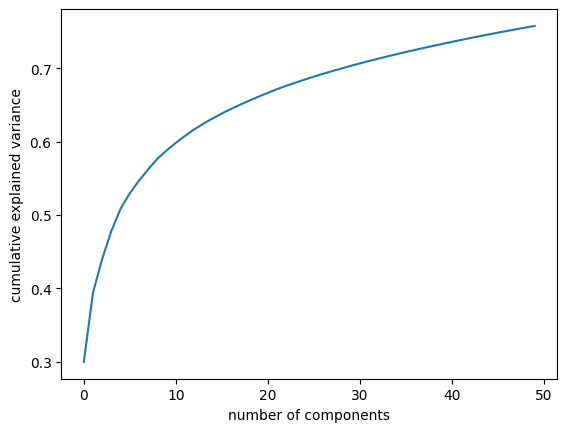

In [33]:
plt.plot(np.cumsum(pca_c1.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

# SVM Training

In [34]:
# With Standard Function PCA
svc_classifier_pca_1 = SVC()
svc_classifier_pca_1.fit(X_train_pca_1, y_train)
y_pred_pca_svc = svc_classifier_pca_1.predict(X_test_pca_1)

print("With Standard Function PCA(SVC)")
print(classification_report(y_test, y_pred_pca_svc, zero_division=1))

With Standard Function PCA(SVC)
                      precision    recall  f1-score   support

            b'Mixed'       1.00      0.00      0.00         4
          b'Partial'       0.77      0.71      0.74        34
              b'Raw'       0.92      0.94      0.93       188
             b'Ripe'       0.85      0.92      0.88       127
b'Rotten_or_Bruised'       0.74      0.61      0.67        38

            accuracy                           0.87       391
           macro avg       0.86      0.63      0.64       391
        weighted avg       0.87      0.87      0.86       391



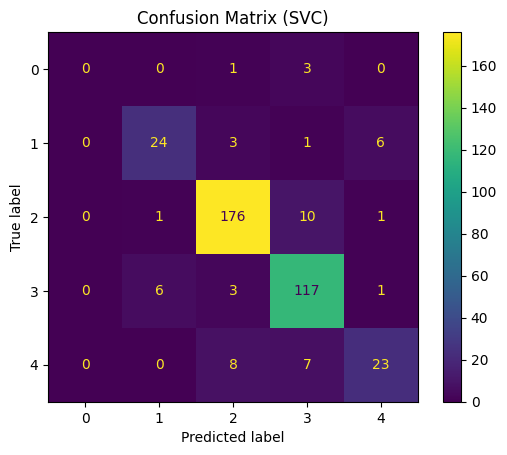

In [35]:
cm = confusion_matrix(y_test, y_pred_pca_svc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (SVC)")
plt.savefig("Confusion Matrix(SVC).jpg") # Save the plot
plt.show()

# KNN Training

In [36]:
# With Standard Function PCA
knn_classifier_pca_std = KNeighborsClassifier(n_neighbors=5)
knn_classifier_pca_std.fit(X_train_pca_1, y_train)
y_pred_knn_pca_std = knn_classifier_pca_std.predict(X_test_pca_1)

print("KNN Classification Report: pca_std")
print(classification_report(y_test, y_pred_knn_pca_std, zero_division=1))

KNN Classification Report: pca_std
                      precision    recall  f1-score   support

            b'Mixed'       1.00      0.00      0.00         4
          b'Partial'       0.47      0.68      0.55        34
              b'Raw'       0.79      0.88      0.83       188
             b'Ripe'       0.85      0.71      0.77       127
b'Rotten_or_Bruised'       0.60      0.39      0.48        38

            accuracy                           0.75       391
           macro avg       0.74      0.53      0.53       391
        weighted avg       0.76      0.75      0.75       391



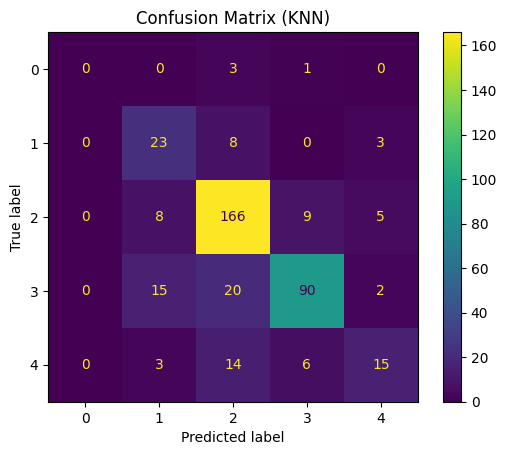

In [37]:
cm = confusion_matrix(y_test, y_pred_knn_pca_std)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (KNN)")
plt.savefig("Confusion Matrix(KNN).jpg") # Save the plot
plt.show()

# XGBoost Training

In [38]:
# With Standard Function PCA
xgboost_classifier_pca = GradientBoostingClassifier()
xgboost_classifier_pca.fit(X_train_pca_1, y_train)
y_pred_xgboost_pca = xgboost_classifier_pca.predict(X_test_pca_1)

print("XGBoost Classification Report: pca_std")
print(classification_report(y_test, y_pred_xgboost_pca, zero_division=1))

XGBoost Classification Report: pca_std
                      precision    recall  f1-score   support

            b'Mixed'       0.50      0.25      0.33         4
          b'Partial'       0.81      0.50      0.62        34
              b'Raw'       0.87      0.93      0.90       188
             b'Ripe'       0.84      0.94      0.89       127
b'Rotten_or_Bruised'       0.67      0.42      0.52        38

            accuracy                           0.84       391
           macro avg       0.74      0.61      0.65       391
        weighted avg       0.83      0.84      0.83       391



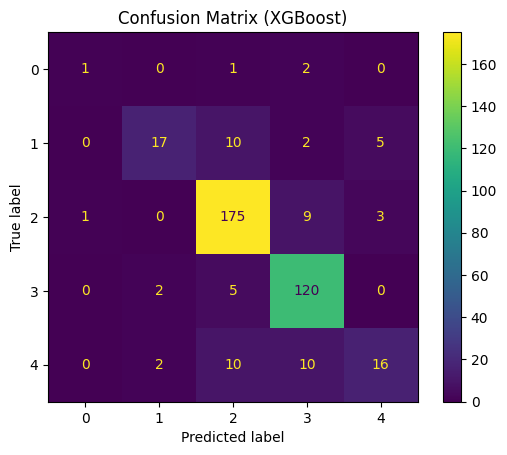

In [39]:
cm = confusion_matrix(y_test, y_pred_xgboost_pca)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (XGBoost)")
plt.savefig("Confusion Matrix(XGBoost).jpg") # Save the plot
plt.show()

# Test The Best Model So Far

In [40]:
def preprocess_single_image(image_path, scaler):
    """
    Preprocesses a single image: resizing, color enhancement, and scaling.
    """
    try:
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at {image_path}")

        # Resize to 256x256
        image = cv2.resize(image, (256, 256))

        # Convert to LAB color space
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)

        # Apply CLAHE to L channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced_l = clahe.apply(l)

        # Merge channels and convert back to BGR
        enhanced_lab = cv2.merge([enhanced_l, a, b])
        processed_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

        # Flatten and scale
        flattened = processed_image.flatten().reshape(1, -1)
        scaled_image = scaler.transform(flattened)

        return scaled_image

    except FileNotFoundError as e:
        print(e)
        return None
    except Exception as e:
        print(f"An error occurred during preprocessing: {e}")
        return None

In [41]:
def predict_image_level(image_path, pca_model, svc_model, scaler):
    """
    Predicts the class of a single image using a trained PCA and SVC model.
    """
    try:
        # Preprocess the image
        preprocessed_image = preprocess_single_image(image_path, scaler)
        if preprocessed_image is None:
            return None

        # Apply PCA transformation
        pca_image = pca_model.transform(preprocessed_image)

        # Predict using the SVC model
        predicted_class = svc_model.predict(pca_image)

        return predicted_class[0]

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [48]:
# Example usage
image_path = '/content/Ripe_Test.jpg'  # Replace with your image path

predicted_level = predict_image_level(image_path, pca_c1, svc_classifier_pca_1,scaler)

if predicted_level is not None:
    print(f"The predicted level for the image is: {predicted_level}")

The predicted level for the image is: b'Ripe'


In [49]:
# Example usage
image_path = '/content/Mixed_Test.jpg'  # Replace with your image path

predicted_level = predict_image_level(image_path, pca_c1, svc_classifier_pca_1,scaler)

if predicted_level is not None:
    print(f"The predicted level for the image is: {predicted_level}")

The predicted level for the image is: b'Mixed'


In [52]:
# Example usage
image_path = '/content/Rotten_Test.jpg'  # Replace with your image path

predicted_level = predict_image_level(image_path, pca_c1, svc_classifier_pca_1,scaler)

if predicted_level is not None:
    print(f"The predicted level for the image is: {predicted_level}")

The predicted level for the image is: b'Rotten_or_Bruised'


In [53]:
# Example usage
image_path = '/content/Raw_Test.jpg'  # Replace with your image path

predicted_level = predict_image_level(image_path, pca_c1, svc_classifier_pca_1,scaler)

if predicted_level is not None:
    print(f"The predicted level for the image is: {predicted_level}")

The predicted level for the image is: b'Raw'


In [58]:
# Example usage
image_path = '/content/Partial_Test.jpg'  # Replace with your image path

predicted_level = predict_image_level(image_path, pca_c1, svc_classifier_pca_1,scaler)

if predicted_level is not None:
    print(f"The predicted level for the image is: {predicted_level}")

The predicted level for the image is: b'Ripe'


# Import The model

In [59]:
import joblib
import pickle

# Save the scikit-learn model

pickle.dump(pca_c1, open('Image_Classifier_pca_c1.pkl','wb'))
pickle.dump(svc_classifier_pca_1, open('Image_Classifier_SVC_1.pkl','wb'))
pickle.dump(knn_classifier_pca_std, open('Image_Classifier_KNN_1.pkl','wb'))
pickle.dump(xgboost_classifier_pca, open('Image_Classifier_XGBoost_1.pkl','wb'))

In [60]:
# Save Function

pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(preprocess_single_image, open('preprocess_single_image.pkl', 'wb'))
pickle.dump(predict_image_level, open('predict_image_level.pkl', 'wb'))